In [3]:
#导入关于Pyspark 相关的包以及初始化相应的 sqlContext， 这两部在spark 处理csv文件是必要的
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

#导入其他相关的包
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arrow as ar
import matplotlib
matplotlib.style.use('ggplot')

In [46]:
from utils import *

ImportError: No module named utils

In [4]:
# 初始化相应的arrow 对象
end_time = ar.get("2016-05-09")#ar.now()
start_time = end_time.replace(days=-3)

start_time = start_time.naive
end_time = end_time.naive

In [9]:
# 初始化hdfs 文件的前缀
prefix = "hdfs://192.168.121.2:8020/demo/"
postfix = ".user.lines.csv"

# prefix + str(start_time.year) + '_0' + str(start_time.month) + "_0" + str(start_time.day) + postfix
# sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true',delimiter=';').load('hdfs://192.168.121.2:8020/demo/2016_05_02.user.lines.csv')


DataFrame[cid: int, phone: bigint, idcard: string, city: string, customer_type: int, reg_time: timestamp, reg_longitude: double, reg_latitude: double, xx: string, tb: int, op: int, jd: int, sina: int, report: int, social: int, contact: int, credit_email: int, bank_card: int, accumulation_fund: int, grant_count: int, tb_amount: int, xx_amount: double, op_amount: double, jd_amount: double, credit_amount: double, sina_amount: double, work_amount: double, cross_amount: double, insurance_amount: double, final_amount: double, first_overdue_day: double, first_extract_time: int, first_extract_time_day: string, first_overdue_status: string, first_extract_amount: int, first_should_date: double, first_end_time: string, anti_fraud_score: string, first_ydk_time: int, first_extract_status: string, first_anti_fraud_score: int, first_extract_id: int, first_periods: int, first_periods_amount: int, need_repay_times: double, need_repay_money: int, already_repay_times: double, already_repay_money: int, al

In [10]:
# 根据时间格式化csv文件并且将读取的Spark DataFrame 对象融合到 spark_df_list
import datetime 

#处理5-2 到 5-9 的csv 文件
spark_df_list = []
temp_start = start_time
while start_time <= end_time:
    temp_end = start_time + datetime.timedelta(days=1)
    file_path = prefix + str(start_time.year) + '_0' + str(start_time.month) + "_0" + str(start_time.day) + postfix

    #append 到list 里去
    spark_df_list.append(sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true',delimiter=';').load(file_path))
    start_time = temp_end

In [12]:
# 将spark_df_list 中的dataform 对象融合到一个pandas DataFrame对象中, 3个csv文件大概需要20s左右吧
df_large = pd.DataFrame()

for df_each_spark in spark_df_list:
    df_large = pd.concat([df_each_spark.toPandas(),df_large])

In [24]:
df_large["reg_time"].describe() #注意此时type 类型是object,

count                  128373
unique                 100677
top       2016-05-07 12:44:23
freq                        8
first     2016-05-06 00:00:02
last      2016-05-09 23:59:56
Name: reg_time, dtype: object

In [34]:
df_large['reg_time']

0       2016-05-09 14:21:01
1       2016-05-09 14:20:56
2       2016-05-09 14:21:05
3       2016-05-09 14:21:03
4       2016-05-09 14:21:10
5       2016-05-09 14:21:07
6       2016-05-09 14:21:12
7       2016-05-09 14:21:11
8       2016-05-09 14:21:15
9       2016-05-09 14:21:13
10      2016-05-09 11:15:52
11      2016-05-09 11:15:52
12      2016-05-09 11:15:50
13      2016-05-09 11:15:50
14      2016-05-09 11:15:48
15      2016-05-09 11:15:46
16      2016-05-09 10:16:53
17      2016-05-09 10:16:52
18      2016-05-09 13:30:03
19      2016-05-09 10:16:53
20      2016-05-09 13:30:03
21      2016-05-09 13:30:03
22      2016-05-09 13:30:06
23      2016-05-09 13:30:04
24      2016-05-09 13:30:09
25      2016-05-09 13:30:06
26      2016-05-09 10:16:58
27      2016-05-09 10:16:55
28      2016-05-09 09:48:23
29      2016-05-09 09:48:19
                ...        
29174   2016-05-06 11:03:00
29175   2016-05-06 11:03:15
29176   2016-05-06 11:03:15
29177   2016-05-06 11:02:48
29178   2016-05-06 1

In [39]:
# reg_date = df_large.reg_time.apply(lambda x : x[:10])#无法进行切片，因为我转换过来的是datetime 对象
reg_date = df_large.reg_time.apply(lambda x : x[:10])
df_large["reg_date"] = reg_date

# df_large['reg_date'].head(5)

In [40]:
grouped_date = df_large.groupby(df_large.reg_date)

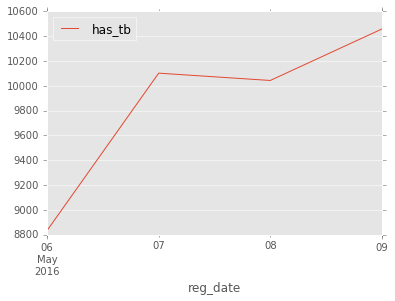

In [41]:
# 如果是单个指标
res = grouped_date.apply(lambda x: pd.Series(
    {
        "has_tb":np.sum(x.tb==1) , # 授权淘宝的人数   
    }
))
res.index=pd.to_datetime(res.index)
res.plot(legend=True) # 绘制一个有图的

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d738150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13c7bcb90>]], dtype=object)

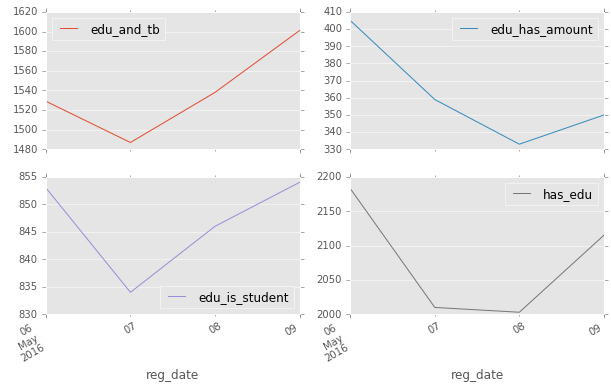

In [45]:
#  多个指标验证
res = grouped_date.apply(lambda x: pd.Series(
    {
        "has_edu":np.sum(x.xx==1), 
        "edu_and_tb": np.sum((x.xx==1) & (x.tb==1)), 
        "edu_has_amount": np.sum(x.xx_amount>0), 
        "edu_is_student":np.sum((x.xx==1) & (x.customer_type==0)),            
    }
))
res.index=pd.to_datetime(res.index)
# res.plot(legend=True, figsize=(10,15)) # 绘制一个有图的
res.plot(subplots=True, figsize=(10,6), layout=(2,2)) 
# figsize 制定 宽 和 高
# layout 制定 行 和 列